In [4]:
import os
import torch
import librosa
import librosa.display
import scipy
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
import math
import copy
import time

## Constants

In [5]:
fs = 16e3 # [Hz] sampling frequency
windowLength = 256 # {from paper}
fftLength = windowLength
overlap = round(0.25 * windowLength) # overlap of 75% makes good prediction; {from paper}
window = scipy.signal.hamming(windowLength, sym=False) # Hamming window {from paper}
numSegments = 8
numFeatures = fftLength // 2 + 1

## Utilities

In [6]:
def read_audio(filepath, sample_rate, normalize=True):
    """Read an audio file and return it as a numpy array"""
    audio, sr = librosa.load(filepath, sr=sample_rate)
    #Normalization?
    if normalize:
        div_fac = 1 / np.max(np.abs(audio)) / 3.0
        audio = audio * div_fac
    return audio, sr
    
def remove_silent_frames(audio, filename):
    
    array_sum = np.sum(audio)
    array_has_nan = np.isnan(array_sum)
    
    if array_has_nan:
        print("NNNNNNNNNNNNNNNNNAAAAAAAAAAAAAAAAAAAAAAAAAAAANNNNNNNNNNNNNNNNNNNNNNNN", filename)
    
    trimed_audio = []
    indices = librosa.effects.split(audio, hop_length = overlap, top_db=20)

    for index in indices:
        trimed_audio.extend(audio[index[0]: index[1]])
    return np.array(trimed_audio)

def add_noise_to_clean_audio(clean_audio, noise_signal):
    """Adds noise to an audio sample"""
    if len(clean_audio) >= len(noise_signal):
        # print("The noisy signal is smaller than the clean audio input. Duplicating the noise.")
        while len(clean_audio) >= len(noise_signal):
            noise_signal = np.append(noise_signal, noise_signal)

    # Extract a noise segment from a random location in the noise file
    ind = np.random.randint(0, noise_signal.size - clean_audio.size)
    
    noise_segment = noise_signal[ind: ind + clean_audio.size]

    speech_power = np.sum(clean_audio ** 2)
    noise_power = np.sum(noise_segment ** 2)
    noisy_audio = clean_audio + np.sqrt(speech_power / noise_power / 4) * noise_segment
    return noisy_audio

def _phase_aware_scaling(clean_spectral_magnitude, clean_phase, noise_phase):
    assert clean_phase.shape == noise_phase.shape, "Shapes must match."
    return clean_spectral_magnitude * np.cos(clean_phase - noise_phase)


def _audio_random_crop(audio, duration):
    audio_duration_secs = librosa.core.get_duration(audio, fs)

    ## duration: length of the cropped audio in seconds
    if duration >= audio_duration_secs:
        print(f"Passed duration {duration} greater than audio duration of { audio_duration_secs}")
        return audio

    audio_duration_ms = math.floor(audio_duration_secs * fs)
    duration_ms = math.floor(duration * fs)
    idx = np.random.randint(0, audio_duration_ms - duration_ms)
    return audio[idx: idx + duration_ms]

def extend_all_speaches_to_same_size(sample_speach_filenames):
    speaches = []
    
    max_length = 0
    for filename in sample_speach_filenames:
        sound_audio, sampl_rate_sound = read_audio(filename, sample_rate=fs)
        if max_length < len(sound_audio):
            max_length = len(sound_audio)
        speaches.append([sound_audio, sampl_rate_sound])
        
    for sound_data in speaches:
        sound_data[0] = np.pad(sound_data[0], (0, max_length - len(sound_data[0])), mode='constant')
        
    return speaches
        
def play_sound(audio, sample_rate):
    ipd.display(ipd.Audio(data=audio, rate=sample_rate)) 
    

In [7]:
def prepare_input_features(stft_features, numSegments, numFeatures):
    #numSegments se ne koristi u FNN
    stftSegments=stft_features[:,None,:]
    return stftSegments

## Dataset

In [38]:
path_to_noise_dataset = "../../dataset/noise_dataset/audio/"
all_noise_filenames = glob.glob(os.path.join(path_to_noise_dataset, 'fold3', '*.*'))
#print(all_noise_filenames[0:10])
#all_noise_filenames = ["../../dataset/noise_dataset/audio/fold3/18594-1-1-0.wav"]

path_to_speach_dataset = "../../dataset/en/clips"
all_speach_filenames = glob.glob(os.path.join(path_to_speach_dataset, '*.*'))
#print(all_speach_filenames[0:10])
#print(len(all_speach_filenames))

## Sound

In [39]:
speach_sample_size = 500 # dataset has ~1e7 sounds, so we need smaller samplegg
sample_speach_filenames = random.sample(all_speach_filenames, speach_sample_size)

print(len(sample_speach_filenames))

train_set_percentage = 70 #%
validation_set_percentage = 20 #%
test_set_percentage = 10 #%

speach_filenames_train, speach_filenames_validation, speach_filenames_test = \
    np.split(sample_speach_filenames, \
             [int(speach_sample_size * train_set_percentage / 100.), \
              int(speach_sample_size * (train_set_percentage + validation_set_percentage) / 100.)])

print(len(speach_filenames_train))
print(len(speach_filenames_validation))
print(len(speach_filenames_test))

500
350
100
50


In [40]:
avg_start_loss=0
def fetch_data_for_nn(sample_speach_filenames):
    speach_data_for_nn = []
    noised_data_for_nn = []
    start_loss=0
    cnt = 0
    for filename in sample_speach_filenames:
         
        if cnt % 5 == 0:
            print(f"Completed: {cnt * 100 / len(sample_speach_filenames):.3f} %")
        cnt += 1
            
        sound_audio, sampl_rate_sound = read_audio(filename, sample_rate=fs)

        #play sound_audio without cutting empty voice
        #play_sound(sound_audio, sampl_rate_sound)

        sound_audio = remove_silent_frames(sound_audio, filename)

        sound_audio = _audio_random_crop(sound_audio, duration = 0.8)
        
        speach_stft = librosa.stft(sound_audio, n_fft=fftLength, win_length=windowLength, hop_length=overlap, window=window, center=True)
        speach_stft_abs = np.abs(speach_stft)
        speach_stft_phase = np.angle(speach_stft)

        #speach_stft_abs_db = librosa.amplitude_to_db(speach_stft_abs,ref=np.max)
        #fig, ax = plt.subplots()
        #img = librosa.display.specshow(speach_stft_abs_db, y_axis='linear', x_axis='time', ax=ax)
        #ax.set_title('Clear speach')
        #fig.colorbar(img, ax=ax, format="%+2.0f dB")

        random_noise_signal_index = np.random.randint(0, len(all_noise_filenames) - 1)
        #print(all_noise_filenames[random_noise_signal_index])
        noise_audio, sampl_rate_noise = read_audio(all_noise_filenames[random_noise_signal_index], sample_rate=fs)

        noise_audio = remove_silent_frames(noise_audio, filename)

        noise_stft = librosa.stft(noise_audio, n_fft=fftLength, win_length=windowLength, hop_length=overlap, window=window, center=True)
        noise_stft_abs = np.abs(noise_stft)
        noise_stft_phase = np.angle(noise_stft)

        #noise_stft_abs_db = librosa.amplitude_to_db(noise_stft_abs,ref=np.max)
    
        noise_and_speach = add_noise_to_clean_audio(sound_audio, noise_audio)    

        noise_and_speach_stft = librosa.stft(noise_and_speach, n_fft=fftLength, win_length=windowLength, hop_length=overlap, window=window, center=True)
        noise_and_speach_stft_abs = np.abs(noise_and_speach_stft)
        noise_and_speach_stft_phase = np.angle(noise_and_speach_stft)

        speach_stft_abs = _phase_aware_scaling(speach_stft_abs, speach_stft_phase, noise_and_speach_stft_phase)
        
        #scaler = StandardScaler(copy=False, with_mean=True, with_std=True)
        #noise_and_speach_stft_abs = scaler.fit_transform(noise_and_speach_stft_abs)
        #speach_stft_abs = scaler.transform(speach_stft_abs)

        noise_and_speach_chunks = prepare_input_features(noise_and_speach_stft_abs, numSegments, numFeatures)

        #print(noise_and_speach_chunks.shape, speach_stft_abs.shape)

        noise_and_speach_chunks = np.transpose(noise_and_speach_chunks, (2, 0, 1))
        speach_stft_abs = np.transpose(speach_stft_abs, (1, 0))
    #    noise_stft_phase = np.transpose(noise_stft_phase, (1, 0))

        #print(noise_and_speach_chunks.shape, speach_stft_abs.shape)

        speach_data_for_nn.append(speach_stft_abs)
        noised_data_for_nn.append(noise_and_speach_chunks)
        
        start_loss+=((noise_and_speach_stft_abs-speach_stft_abs.T)**2).mean()
        #play sound_audio
        #play_sound(sound_audio, sampl_rate_sound)
        #play noise_audio
        #play_sound(noise_audio, sampl_rate_noise)
        #play noise_and_speach
        #play_sound(noise_and_speach, sampl_rate_sound)

        #print(noise_and_speach_stft_abs.shape)
        #print("--")

    #print("++")
    avg_start_loss=start_loss/len(sample_speach_filenames)
    print("Avg start loss:",start_loss/len(sample_speach_filenames))
    
    speach_data_for_nn = np.concatenate(speach_data_for_nn)
    speach_data_for_nn = speach_data_for_nn[:,:,None]
    noised_data_for_nn = np.concatenate(noised_data_for_nn)
    
    return noised_data_for_nn, speach_data_for_nn

In [41]:
# train data fetch
train_noised_data_for_nn, train_speach_data_for_nn = fetch_data_for_nn(speach_filenames_train)
train_noised_data_for_nn = train_noised_data_for_nn.astype(np.float32)
train_speach_data_for_nn = train_speach_data_for_nn.astype(np.float32)


print(train_noised_data_for_nn.shape, train_speach_data_for_nn.shape)

# validation data fetch
validation_noised_data_for_nn, validation_speach_data_for_nn = fetch_data_for_nn(speach_filenames_validation)
validation_noised_data_for_nn = validation_noised_data_for_nn.astype(np.float32)
validation_speach_data_for_nn = validation_speach_data_for_nn.astype(np.float32)

print(validation_noised_data_for_nn.shape, validation_speach_data_for_nn.shape)

# test data fetch
test_noised_data_for_nn, test_speach_data_for_nn = fetch_data_for_nn(speach_filenames_test)
test_noised_data_for_nn = test_noised_data_for_nn.astype(np.float32)
test_speach_data_for_nn = test_speach_data_for_nn.astype(np.float32)

print(test_noised_data_for_nn.shape, test_speach_data_for_nn.shape)



Completed: 0.000 %
Completed: 1.429 %
Completed: 2.857 %
Completed: 4.286 %
Completed: 5.714 %
Completed: 7.143 %
Completed: 8.571 %
Completed: 10.000 %
Completed: 11.429 %
Completed: 12.857 %
Completed: 14.286 %
Completed: 15.714 %
Completed: 17.143 %
Completed: 18.571 %
Completed: 20.000 %
Completed: 21.429 %
Completed: 22.857 %
Completed: 24.286 %
Passed duration 0.8 greater than audio duration of 0.796
Completed: 25.714 %
Completed: 27.143 %
Completed: 28.571 %
Completed: 30.000 %
Completed: 31.429 %
Completed: 32.857 %
Completed: 34.286 %
Passed duration 0.8 greater than audio duration of 0.456
Completed: 35.714 %
Completed: 37.143 %
Completed: 38.571 %
Completed: 40.000 %
Completed: 41.429 %
Completed: 42.857 %
Completed: 44.286 %
Passed duration 0.8 greater than audio duration of 0.532
Completed: 45.714 %
Completed: 47.143 %
Completed: 48.571 %
Completed: 50.000 %
Completed: 51.429 %
Completed: 52.857 %
Completed: 54.286 %
Completed: 55.714 %
Completed: 57.143 %
Completed: 58.57

In [42]:
avg_start_loss

0

In [43]:
print(speach_filenames_train[4])


../../dataset/en/clips\common_voice_en_17280518.mp3


## Dataset and Dataloader

In [44]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

batch_size = 2048

In [45]:
train_set=TensorDataset(torch.from_numpy(train_noised_data_for_nn), torch.from_numpy(train_speach_data_for_nn))
train_loader=DataLoader(train_set, batch_size=batch_size, shuffle=True)


validation_set=TensorDataset(torch.from_numpy(validation_noised_data_for_nn), torch.from_numpy(validation_speach_data_for_nn))
validation_loader=DataLoader(train_set, batch_size = batch_size, shuffle = True)

#data_set = {'train': train_l}

test_set=TensorDataset(torch.from_numpy(test_noised_data_for_nn), torch.from_numpy(test_speach_data_for_nn))
test_loader=DataLoader(train_set, batch_size = batch_size, shuffle = True)



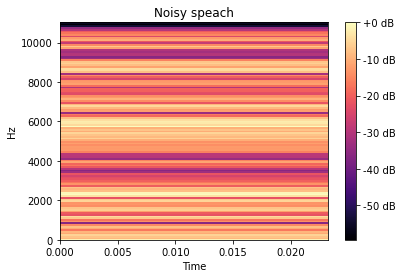

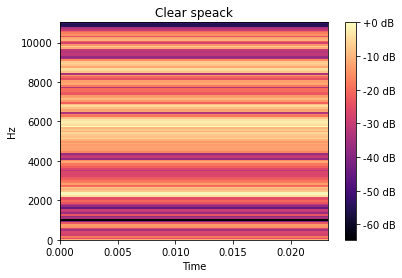

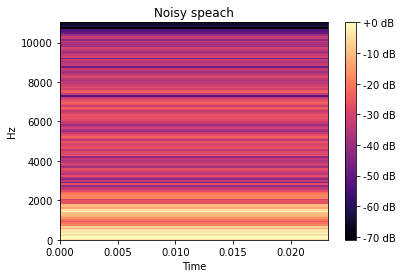

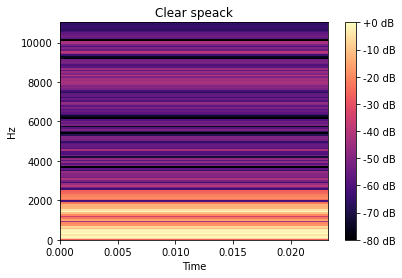

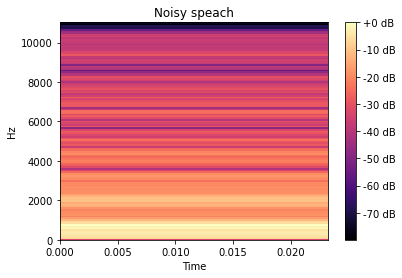

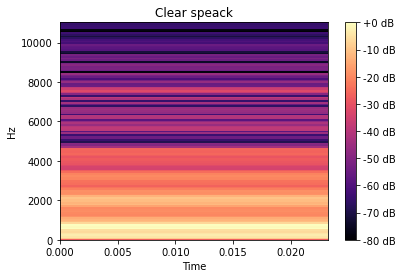

In [46]:

for xb,yb in train_loader:

    for i in range(len(xb)):
        
        play_sound(xb[1], fs)
        play_sound(yb[1], fs)
        
        noise_and_speach_stft_abs_db = librosa.amplitude_to_db(xb[1],ref=np.max)
        fig, ax = plt.subplots()
        img = librosa.display.specshow(noise_and_speach_stft_abs_db, y_axis='linear', x_axis='time', ax=ax)
        ax.set_title('Noisy speach')
        fig.colorbar(img, ax=ax, format="%+2.0f dB")

        noise_and_speach_stft_abs_db = librosa.amplitude_to_db(yb[1],ref=np.max)
        fig, ax = plt.subplots()
        img = librosa.display.specshow(noise_and_speach_stft_abs_db, y_axis='linear', x_axis='time', ax=ax)
        ax.set_title('Clear speack')
        fig.colorbar(img, ax=ax, format="%+2.0f dB")

        break
    break

for xb,yb in validation_loader:

    for i in range(len(xb)):
        noise_and_speach_stft_abs_db = librosa.amplitude_to_db(xb[1],ref=np.max)
        fig, ax = plt.subplots()
        img = librosa.display.specshow(noise_and_speach_stft_abs_db, y_axis='linear', x_axis='time', ax=ax)
        ax.set_title('Noisy speach')
        fig.colorbar(img, ax=ax, format="%+2.0f dB")

        noise_and_speach_stft_abs_db = librosa.amplitude_to_db(yb[1],ref=np.max)
        fig, ax = plt.subplots()
        img = librosa.display.specshow(noise_and_speach_stft_abs_db, y_axis='linear', x_axis='time', ax=ax)
        ax.set_title('Clear speack')
        fig.colorbar(img, ax=ax, format="%+2.0f dB")

        break
    break

for xb,yb in test_loader:

    for i in range(len(xb)):
        noise_and_speach_stft_abs_db = librosa.amplitude_to_db(xb[1],ref=np.max)
        fig, ax = plt.subplots()
        img = librosa.display.specshow(noise_and_speach_stft_abs_db, y_axis='linear', x_axis='time', ax=ax)
        ax.set_title('Noisy speach')
        fig.colorbar(img, ax=ax, format="%+2.0f dB")

        noise_and_speach_stft_abs_db = librosa.amplitude_to_db(yb[1],ref=np.max)
        fig, ax = plt.subplots()
        img = librosa.display.specshow(noise_and_speach_stft_abs_db, y_axis='linear', x_axis='time', ax=ax)
        ax.set_title('Clear speack')
        fig.colorbar(img, ax=ax, format="%+2.0f dB")

        break
    break
        

## Model

In [47]:
import torch.nn as nn
import torch.optim as optim

### Hyperparameters

In [48]:
learning_rate = 0.0015

In [49]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    def forward(self, x):
        return self.func(x)

In [50]:
class PrintShape(nn.Module):
    def __init__(self,i):
        super().__init__()
        self.i=i
    def forward(self, x):
        print("PrintShape: stage:",self.i,"shape",x.shape)
        return x

In [51]:
class SaveConnection(nn.Module):
    def __init__(self,i):
        super().__init__()
        #print("lista sad init:",saved_connections)
        self.i=i
        #if i==0:
        #    saved_connections=[]
        if self.i==len(saved_connections):
            saved_connections.append(-1)
        else:
            print("dodaje se konekcija na lose mesto: i,len:",i,len(saved_connections))
    def forward(self, x):
        saved_connections[self.i]=x
        return x

In [52]:
class AddConnection(nn.Module):
    def __init__(self,index):
        super().__init__()
        self.index=index
    def forward(self,x):
        return saved_connections[self.index]+x

In [53]:
#(Conv, ReLU, BN)  15, Conv.
#(18-30-8)  5, 1 (9-5-9)  5, 129
saved_connections=[]


model = nn.Sequential(
    Lambda(lambda x: x.view(-1, 1, numFeatures)),
    #PrintShape(0),

    nn.Linear(numFeatures, 1024),
    nn.ReLU(),
    
    nn.Linear(1024, 1024),
    nn.ReLU(),
    
    nn.Linear(1024, 1024),
    nn.ReLU(),
    
    nn.Linear(1024,numFeatures)

)

device=torch.device("cuda")
model.to(device)

print(f"Using device {device}, (cuda:0 is prefered over CPU).")  

#optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum = 0.9)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)


Using device cuda, (cuda:0 is prefered over CPU).


In [54]:
lambd=10e-5
def loss_mse(a, b):
    l2_reg = torch.tensor(0.).to(device)
    l=((a - b) ** 2).mean()
    for param in model.parameters():
        l2_reg += torch.norm(param)
    #print(l)
    return l+l2_reg*lambd

In [55]:
next(model.parameters()).is_cuda

True

## Train

In [56]:

for xb,yb in train_loader:
    
    xb,yb=xb.to(device),yb.to(device)
    print("xb size",xb.size(0))
    print(len(train_loader))

    pred = model(xb)
    print("pred, yb shape:",pred.shape,yb.shape)
    
    pred=pred.squeeze()
    yb=yb.squeeze()
    print("squeezed pred, yb shape:",pred.shape,yb.shape)
         
    loss = loss_mse(pred, yb)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print("-"*10)
    break

print("pred-yb shape:",(pred-yb).shape)

xb size 2048
34
pred, yb shape: torch.Size([2048, 1, 129]) torch.Size([2048, 129, 1])
squeezed pred, yb shape: torch.Size([2048, 129]) torch.Size([2048, 129])
----------
pred-yb shape: torch.Size([2048, 129])


In [57]:
print(len(saved_connections))

0


In [58]:
print(len(train_loader.dataset))

69562


In [59]:
num_epochs = 70
best_model_weights={}

def train_model(model, optimizer, num_epochs):
    metrics = defaultdict(list)
    first_epoch=True
    best_loss=0
    best_epoch=0
    learning_rate_divider=1
    number_of_lr_dividing=0
    start_time=time.time()
    
    print("Velicina seta:",len(train_loader.dataset))
    print("Pocetni loss:",avg_start_loss)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # training
        running_loss = 0.0
        #running_corrects = 0
        
        model.train()
        
        for xb,yb in train_loader:
            
            xb,yb=xb.to(device),yb.to(device)

            pred = model(xb)
            
            #print("before:",pred.shape,yb.shape)
            #pred=pred.squeeze()
            #yb=yb.squeeze()
            #print("after:",pred.shape,yb.shape)
            
            #_, preds = torch.max(pred, 1)            
            loss = loss_mse(pred.squeeze(), yb.squeeze())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # statistics
            #print("trenutni loss",loss.item(),xb.size(0))
            running_loss += loss.item() * xb.size(0)
            
            #print("shapes:",preds.shape,yb.data.shape)
            #running_corrects += torch.sum(preds == yb.data).item()
        #print("Na kraju loss:",running_loss, len(train_loader))
        epoch_loss = running_loss / len(train_loader.dataset)
        #epoch_acc = float(running_corrects) / len(train_loader)           

        print(f'Training Loss: {epoch_loss:.4f}')

        metrics["train" + "_loss"].append(epoch_loss)
        #metrics["train" + "_acc"].append(epoch_acc)

        
        # validation
        running_loss = 0.0
        #running_corrects = 0
        
        model.eval()

        for xb,yb in validation_loader:
            xb,yb=xb.to(device),yb.to(device)

            pred=model(xb)
            

            #_, preds = torch.max(pred, 1)            
            loss = loss_mse(pred.squeeze(), yb.squeeze())

            # statistics
            running_loss += loss.item() * xb.size(0)
            #running_corrects += torch.sum(preds == yb.data).item()
            
        epoch_loss = running_loss / len(validation_loader.dataset)
        #epoch_acc = float(running_corrects) / len(validation_loader)   
        
        if first_epoch:
            best_loss=epoch_loss
            best_epoch=0
            first_epoch=False
        elif epoch_loss<=best_loss:
            best_epoch=epoch
            best_loss=epoch_loss
            best_model_weights=copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(),"C:\\Users\\psiml\\Desktop\\model\\fnnVise.pth")
        else:
            print("Trenutni model nije sacuvan jer je loss veci sad")
        
        if epoch-best_epoch>0 and (epoch-best_epoch)%4==0:
            print("Learning rate se polovi!")
            for param_group in optimizer.param_groups:
                param_group['lr'] = learning_rate*learning_rate_divider/(learning_rate_divider+1)
            learning_rate_divider+=1
            number_of_lr_dividing+=1

        print(f'Validation Loss: {epoch_loss:.4f}')
        print("Learning rate divider",learning_rate_divider)

        
        metrics["val" + "_loss"].append(epoch_loss)
        #metrics["val" + "_acc"].append(epoch_acc)

        #print(f"Epoch {epoch}: {avg_loss:.3f}")
        
        
        # deep copy the model
        #if epoch_acc > best_acc:
        #    best_acc = epoch_acc
        #    best_model_wts = copy.deepcopy(model.state_dict())
        
        print("Vreme od pocetka simulacije:",(time.time()-start_time),"sekundi")
        
    model.load_state_dict(best_model_weights)
    print("Broj polovljenja:",number_of_lr_dividing)
    
    return model.state_dict(), metrics, best_epoch


In [60]:
trained_model, metrics, best_epoch = train_model(model, optimizer, num_epochs)

Velicina seta: 69562
Pocetni loss: 0
Epoch 0/69
----------
Training Loss: 0.1276
Validation Loss: 0.0698
Learning rate divider 1
Vreme od pocetka simulacije: 2.907000780105591 sekundi
Epoch 1/69
----------
Training Loss: 0.0581
Validation Loss: 0.0499
Learning rate divider 1
Vreme od pocetka simulacije: 5.806000709533691 sekundi
Epoch 2/69
----------
Training Loss: 0.0469
Validation Loss: 0.0441
Learning rate divider 1
Vreme od pocetka simulacije: 8.7260000705719 sekundi
Epoch 3/69
----------
Training Loss: 0.0426
Validation Loss: 0.0408
Learning rate divider 1
Vreme od pocetka simulacije: 11.625997543334961 sekundi
Epoch 4/69
----------
Training Loss: 0.0401
Validation Loss: 0.0387
Learning rate divider 1
Vreme od pocetka simulacije: 14.5241117477417 sekundi
Epoch 5/69
----------
Training Loss: 0.0380
Validation Loss: 0.0369
Learning rate divider 1
Vreme od pocetka simulacije: 17.450339794158936 sekundi
Epoch 6/69
----------
Training Loss: 0.0367
Validation Loss: 0.0363
Learning rate 

Training Loss: 0.0226
Validation Loss: 0.0220
Learning rate divider 1
Vreme od pocetka simulacije: 147.79702162742615 sekundi
Epoch 51/69
----------
Training Loss: 0.0225
Validation Loss: 0.0219
Learning rate divider 1
Vreme od pocetka simulacije: 150.67655396461487 sekundi
Epoch 52/69
----------
Training Loss: 0.0225
Trenutni model nije sacuvan jer je loss veci sad
Validation Loss: 0.0226
Learning rate divider 1
Vreme od pocetka simulacije: 153.52577924728394 sekundi
Epoch 53/69
----------
Training Loss: 0.0223
Validation Loss: 0.0217
Learning rate divider 1
Vreme od pocetka simulacije: 156.41889667510986 sekundi
Epoch 54/69
----------
Training Loss: 0.0225
Trenutni model nije sacuvan jer je loss veci sad
Validation Loss: 0.0218
Learning rate divider 1
Vreme od pocetka simulacije: 159.25246357917786 sekundi
Epoch 55/69
----------
Training Loss: 0.0219
Validation Loss: 0.0217
Learning rate divider 1
Vreme od pocetka simulacije: 162.14248132705688 sekundi
Epoch 56/69
----------
Training

Best epoch is: 67


<Figure size 432x288 with 0 Axes>

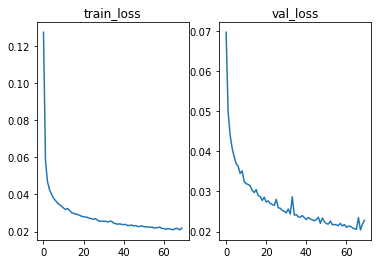

In [61]:
plt.subplots_adjust(wspace=1, hspace=1)
fig, ax = plt.subplots(nrows=1, ncols=2)
keys = list(metrics.keys())
cnt = 0
print("Best epoch is:",best_epoch)
for col in ax:
    col.set_title(keys[cnt])
    col.plot(metrics[keys[cnt]])
    cnt += 1

In [ ]:
torch.save(model.state_dict(),"C:\\Users\\psiml\\Desktop\\model\\modelNedeljaUjutru.pth")
#torch.save(model.state_dict(),"D:\model")

In [135]:
speach_filenames_test

array(['../../dataset/en/clips\\common_voice_en_18453744.mp3',
       '../../dataset/en/clips\\common_voice_en_127444.mp3'], dtype='<U51')

In [155]:
model3=torch.load("C:\\Users\\psiml\\Desktop\\model\\model.pth")
#model = TheModelClass(*args, **kwargs)
#model.load_state_dict(torch.load("C:\\Users\\psiml\\Desktop\\model\\model.pth"))

In [143]:
model2

OrderedDict([('2.weight',
              tensor([[[[-2.1364e-01, -3.6195e-01, -2.8195e-01,  ..., -4.2636e-01,
                         -4.3159e-01, -5.3954e-01],
                        [ 1.7942e-01,  6.8752e-02, -1.4616e-02,  ..., -7.0994e-02,
                         -1.2457e-01, -2.8831e-01],
                        [ 2.8179e-01,  9.1423e-02,  4.1816e-02,  ...,  1.3120e-01,
                          1.8940e-01,  4.2345e-02],
                        ...,
                        [ 1.3742e-01,  4.5056e-02, -7.9283e-02,  ...,  2.5795e-01,
                          7.0045e-02, -9.6678e-02],
                        [-6.2777e-03, -1.1530e-01,  2.4537e-02,  ...,  1.1392e-01,
                          4.4201e-03,  2.0985e-01],
                        [ 2.4196e-02,  1.1799e-02,  2.0957e-02,  ...,  1.3630e-01,
                          3.8654e-02,  5.3105e-02]]],
              
              
                      [[[ 1.1326e-01,  1.2365e-01,  3.5029e-02,  ...,  4.2054e-02,
                    

In [396]:
torch.backends.cudnn.enabled

True

In [397]:
model

Sequential(
  (0): Lambda()
  (1): Conv2d(1, 18, kernel_size=(9, 8), stride=(1, 1), padding=(4, 0), bias=False)
  (2): ReLU()
  (3): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Conv2d(18, 30, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0), bias=False)
  (5): SaveConnection()
  (6): ReLU()
  (7): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Conv2d(30, 8, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0), bias=False)
  (9): ReLU()
  (10): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Conv2d(8, 18, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0), bias=False)
  (12): ReLU()
  (13): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): Conv2d(18, 30, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0), bias=False)
  (15): SaveConnection()
  (16): ReLU()
  (17): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_st

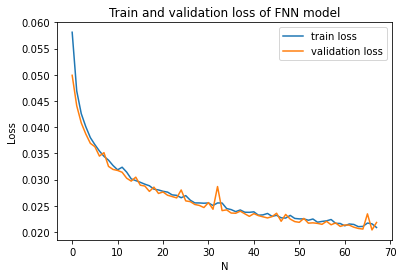

In [62]:
beg = 1
end = 69
plt.plot(metrics['train_loss'][beg:end])
plt.plot(metrics['val_loss'][beg:end])
plt.title("Train and validation loss of FNN model")
plt.legend(['train loss', 'validation loss'])
plt.xlabel('N')
plt.ylabel('Loss')
plt.savefig('FNN_loss.png', dpi = 90)
plt.show()